# 特征工程的神器-基于Python的特征自动化选择代码
>本文介绍一个特征选择神器：特征选择器是用于减少机器学习数据集的维数的工具，可以傻瓜式地进行特征选择。
>
>来源：[Will Koehrsen](https://github.com/WillKoehrsen)
>
>代码整理及注释翻译：[黄海广](https://github.com/fengdu78)

## 实现的功能
该选择器基于python编写，有五种方法来标识要删除的特征：

- 缺失值
- 唯一值
- 共线特征
- 零重要性特征
- 低重要性特征

## 使用方法


在这个Jupyter文件中， 我们将使用 `FeatureSelector` 类来选择数据集中要删除的特征，这个类提供五种方法来查找要删除的功能：  

1. 查找缺失分数大于指定阈值的列
2. 查找只有唯一值的特征
3. 查找由相关系数大于指定值的共线特征
4. 使用梯度增强算法查找具有零重要性的特征
5. 使用梯度增强算法查找中查找对指定的累积特征重要性无贡献的特征 

 `FeatureSelector` 仍在进一步开发中! 欢迎大家在github提交PR.

In [1]:
from feature_selector import FeatureSelector

import pandas as pd

### 示例数据集

该数据集被用作Kaggle上房屋信用违约风险竞赛的(https://www.kaggle.com/c/home-credit-default-risk)  一部分(数据放在`data`目录里)。它旨在用于有监督的机器学习分类任务，其目的是预测客户是否会拖欠贷款。您可以在此处下载整个数据集，我们将处理10,000行的一小部分样本。

特征选择器旨在用于机器学习任务，但可以应用于任何数据集。基于特征重要性的方法需要使用机器学习的监督学习问题。

In [2]:
train = pd.read_csv('data/credit_example.csv')
train_labels = train['TARGET']
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247408,0,Cash loans,F,Y,N,2,108000.0,172512.0,13477.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,153916,0,Revolving loans,F,Y,Y,2,135000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,229065,0,Cash loans,F,N,Y,0,112500.0,463500.0,20547.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,7.0
3,282013,0,Cash loans,F,N,Y,0,135000.0,549882.0,17739.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,142266,0,Cash loans,F,N,Y,0,90000.0,518562.0,20695.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


数据集中有几个分类列。`FeatureSelector`处理这些特征重要性的时候使用独热编码。 

In [3]:
train = train.drop(columns = ['TARGET'])

### 实施

在`FeatureSelector`具有用于标识列，以除去五种特征 :

* `identify_missing`（查找缺失值）
* `identify_single_unique`（查找唯一值）
* `identify_collinear`（查找共线特征）
* `identify_zero_importance` （查找零重要特征）
* `identify_low_importance`（查找低重要特征）

这些方法找到要根据指定条件删除的特征。 标识的特征存储在 `FeatureSelector`的 `ops` 属性（Python词典）中。 我们可以手动删除已识别的特征，也可以使用 `FeatureSelector`中的删除特征函数真正删除特征。

### 创建实例

`FeatureSelector` 仅需要一个在行中具有观察值而在列中具有特征的数据集（标准结构化数据）。 我们正在处理机器学习的分类问题，因此我们也需要训练的标签。

In [4]:
fs = FeatureSelector(data = train, labels = train_labels)

#### 1. 缺失值

第一种特征选择方法很简单：找到丢失分数大于指定阈值的任何列。 在此示例中，我们将使用阈值0.6，这对应于查找缺失值超过60％的特征。 （此方法不会首先对特征进行一次独热编码）。

In [5]:
fs.identify_missing(missing_threshold=0.6)

17 features with greater than 0.60 missing values.



 可以通过 `FeatureSelector` 对象的`ops`词典访问已确定要删除的特征。  

In [6]:
missing_features = fs.ops['missing']
missing_features[:10]

['OWN_CAR_AGE',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'FLOORSMIN_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMENTS_MODE']

我们还可以绘制数据集中所有列的缺失列分数的直方图。

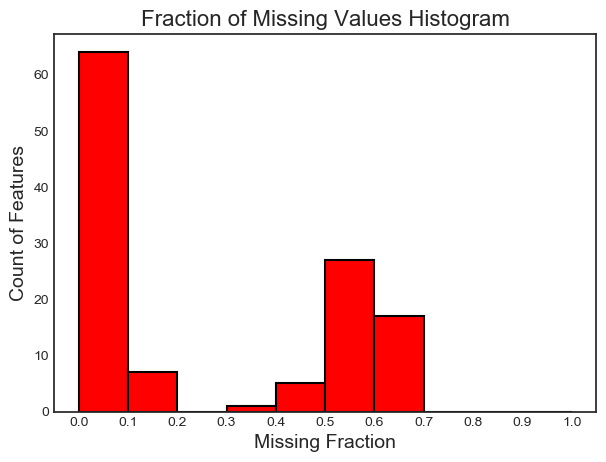

In [7]:
fs.plot_missing()

有关缺失分数的详细信息，我们可以访问`missing_stats`属性，这是所有特征缺失分数的DataFrame。

In [8]:
fs.missing_stats.head(10)

,missing_fraction
COMMONAREA_AVG,0.6953
COMMONAREA_MODE,0.6953
COMMONAREA_MEDI,0.6953
NONLIVINGAPARTMENTS_AVG,0.6945
NONLIVINGAPARTMENTS_MODE,0.6945
NONLIVINGAPARTMENTS_MEDI,0.6945
LIVINGAPARTMENTS_MEDI,0.6846
LIVINGAPARTMENTS_AVG,0.6846
LIVINGAPARTMENTS_MODE,0.6846
FONDKAPREMONT_MODE,0.6820


#### 2. 唯一值

下一个方法很简单：找到只有一个唯一值的所有特征。 （这不会对特征进行独热编码）。

In [9]:
fs.identify_single_unique()

4 features with a single unique value.



In [10]:
single_unique = fs.ops['single_unique']
single_unique

['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17']

我们可以绘制数据集中每个特征中唯一值数量的直方图。

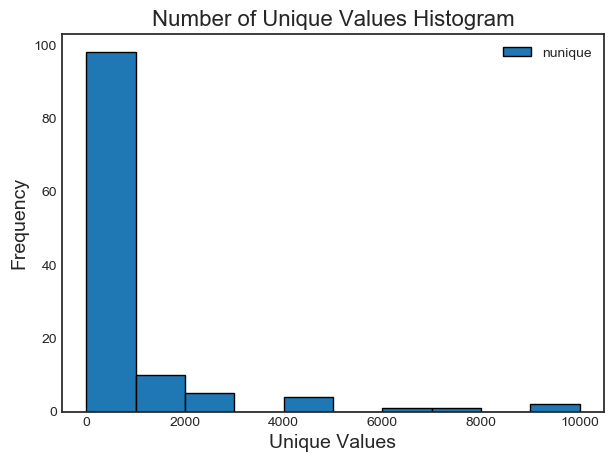

In [11]:
fs.plot_unique()

最后，我们可以访问一个DataFrame，其中包含每个特征的唯一值数量。

In [12]:
fs.unique_stats.sample(5)

,nunique
CODE_GENDER,3
REG_CITY_NOT_LIVE_CITY,2
FLAG_DOCUMENT_10,1
ENTRANCES_MEDI,41
LANDAREA_AVG,1477


#### 3. 共线(高相关性) 特征

该方法基于皮尔森相关系数找到共线特征对。 对于高于指定阈值（就绝对值而言）的每一对，它标识要删除的变量之一。 我们需要传递一个 `correlation_threshold`。

此方法基于在：https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ 中找到的代码。

对于每一对，将要删除的特征是在DataFrame中列排序方面排在最后的特征。 （除非`one_hot = True`，否则此方法不会预先对数据进行一次独热编码。因此，仅在数字列之间计算相关性）

In [13]:
fs.identify_collinear(correlation_threshold=0.975)

24 features with a correlation magnitude greater than 0.97.



In [14]:
correlated_features = fs.ops['collinear']
correlated_features[:5]

['AMT_GOODS_PRICE',
 'FLAG_EMP_PHONE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE']

我们可以查看阈值以上相关性的热图。 将要删除的特征位于x轴上。

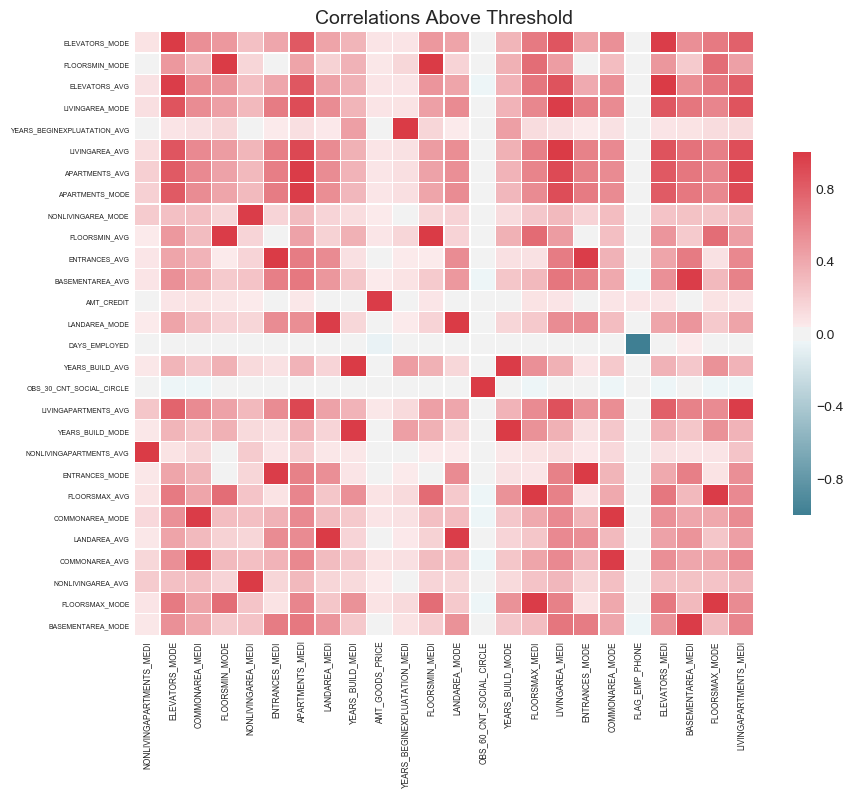

In [15]:
fs.plot_collinear()

要绘制数据中的所有相关性，我们可以将 `plot_all = True` 传递给 `plot_collinear`函数。

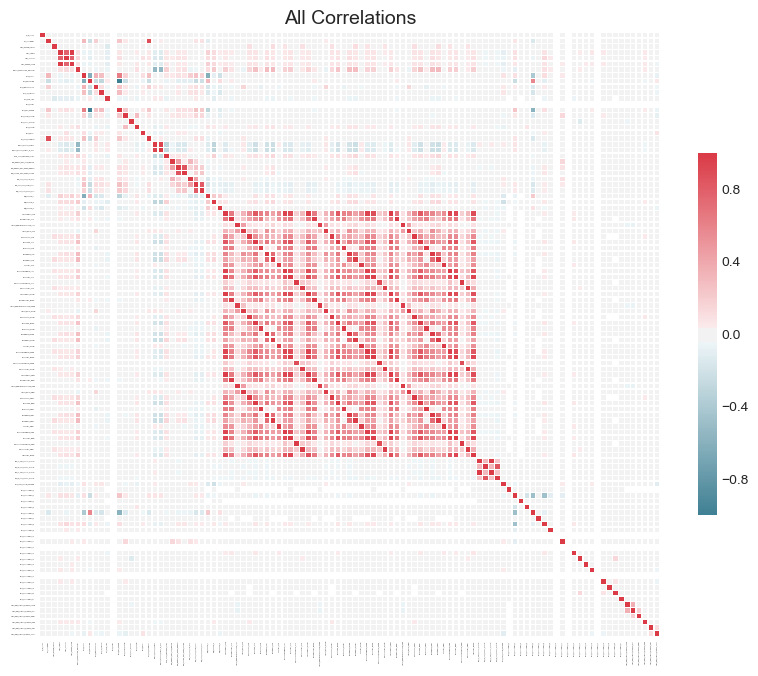

In [16]:
fs.plot_collinear(plot_all=True)

21 features with a correlation magnitude greater than 0.98.



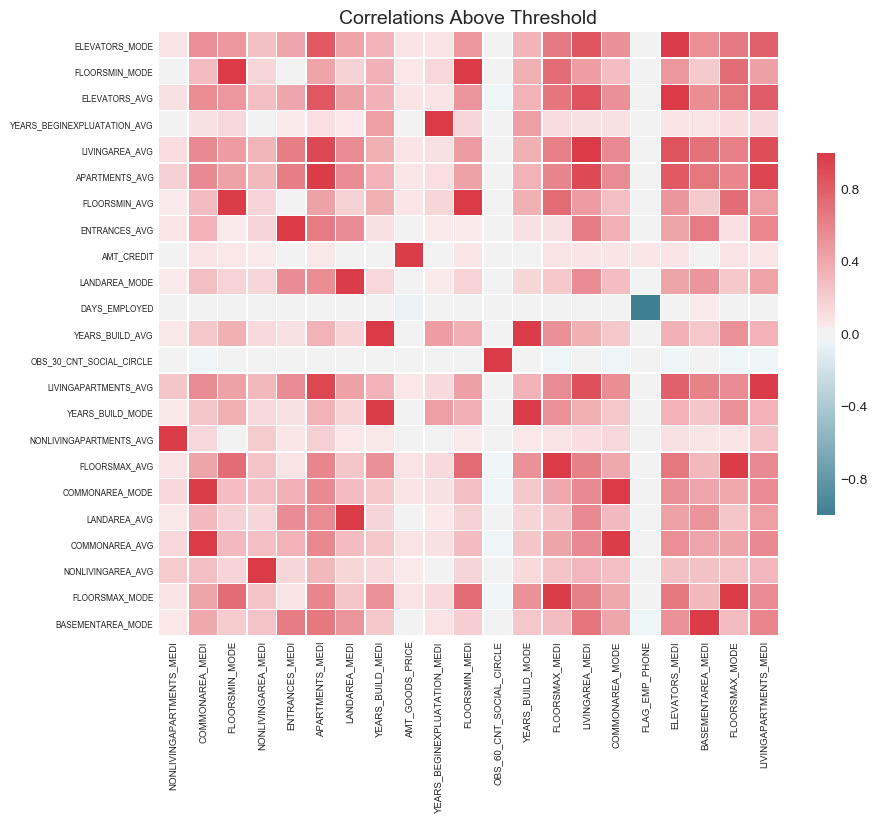

In [17]:
fs.identify_collinear(correlation_threshold=0.98)
fs.plot_collinear()

要查看阈值以上的相关细节，我们访问`record_collinear` 属性，它是一个DataFrame。  `drop_feature` 将被删除，并且对于每个将被删除的特征，它与 `corr_feature`可能存在多个相关性，而这些相关性都高于`correlation_threshold`。

In [18]:
fs.record_collinear.head()

,corr_feature,corr_value,drop_feature
0,AMT_CREDIT,0.987232,AMT_GOODS_PRICE
1,DAYS_EMPLOYED,-0.999533,FLAG_EMP_PHONE
2,YEARS_BUILD_AVG,0.992120,YEARS_BUILD_MODE
3,COMMONAREA_AVG,0.988074,COMMONAREA_MODE
4,FLOORSMAX_AVG,0.984663,FLOORSMAX_MODE


#### 4. 零重要特征
此方法依赖于机器学习模型来识别要删除的特征。 因此，它是有标签的监督学习问题。 该方法通过使用LightGBM库中实现的梯度增强机找到特征重要性。

为了减少所计算的特征重要性的差异，默认情况下对模型进行了10次训练。 默认情况下，还使用验证集（训练数据的15％）通过提前停止训练模型，以识别要训练的最优估计量。 可以将以下参数传递给`identify_zero_importance` 方法：

* `task`: 可以是 `classification` 或 `regression`。 指标和标签必须与任务匹配。
* `eval_metric`: 用于提前停止的度量（例如，用于分类的auc或用于回归的`l2` ）。 要查看可用指标的列表，请参阅LightGBM文档：(http://testlightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters)。
* `n_iterations`: 训练次数。 特征重要性是在训练运行中平均得出的 (默认为10)。
* `early_stopping`: 训练模型时是否使用提前停止（默认= True）。 当验证集的性能对于指定数量的估计量（此实现中默认为100）不再降低时，提早停止将停止训练估计量（决策树）。 早停是一种正则化形式，用于防止训练数据过拟合。

首先对数据进行一次独热编码，以供模型使用。 这意味着某些零重要性特征可以通过一键编码来创建。 要查看单编码的列，我们可以访问 `FeatureSelector`的`one_hot_features` 。

**注意**：与其他方法相比，模型的特征重要性是不确定的（具有少许随机性）。 每次运行此方法时，其结果都可能更改。

In [19]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.254264	valid_0's auc: 0.746911
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.251856	valid_0's auc: 0.75226
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.258582	valid_0's auc: 0.747935
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.254186	valid_0's auc: 0.754061
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.266813	valid_0's auc: 0.722839
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.254795	valid_0's auc: 0.75

运行梯度提升模型需要对特征进行独热编码。 这些特征保存在 `FeatureSelector`的 `one_hot_features` 属性中。 原始特征保存在`base_features`中。

In [20]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 121 original features
There are 134 one-hot features


`FeatureSelector` 的 `data` 属性保存原始DataFrame。 独热编码后， `data_all`属性将保留原始数据以及独热编码特征。

In [21]:
fs.data_all.head(10)

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,7.0
3,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
5,1,0,1,0,0,0,1,1,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
7,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
8,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0,0,1,0,0,1,0,1,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


我们可以使用多种方法来检查特征重要性的结果。 首先，我们可以访问具有零重要性的特征列表。

In [22]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[10:15]

['ORGANIZATION_TYPE_Mobile',
 'ORGANIZATION_TYPE_Military',
 'ORGANIZATION_TYPE_Legal Services',
 'FLAG_DOCUMENT_7',
 'ORGANIZATION_TYPE_Trade: type 2']

#### 画出特征重要性

使用 `plot_feature_importances` 的特征重要性画图将向我们显示 `plot_n` 最重要的特征（按归一化比例将特征加总为1）。 它还向我们显示了累积特征重要性与特征数量之间的关系。

当我们绘制特征重要性时，我们可以传递一个阈值，该阈值标识达到指定的累积特征重要性所需的特征数量。 例如，`threshold = 0.99`将告诉我们占总重要性的99％所需的特征数量。

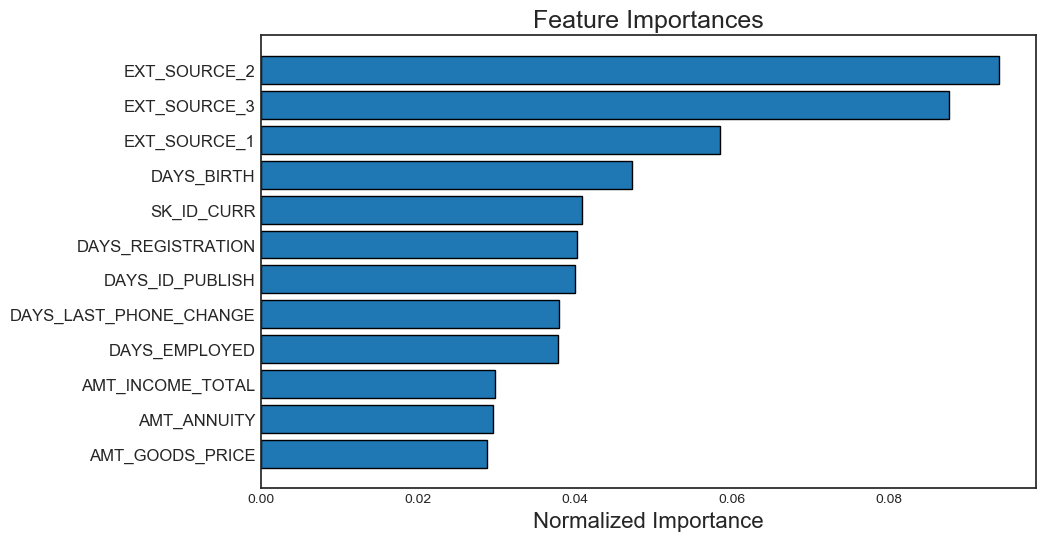

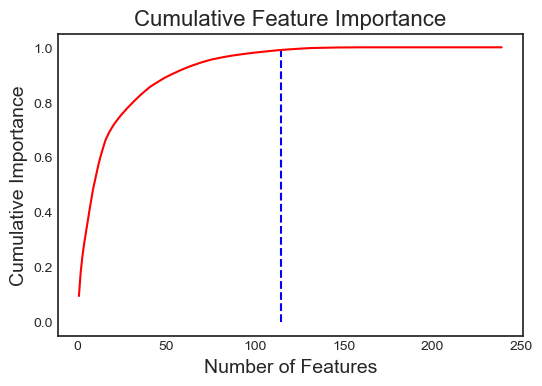

115 features required for 0.99 of cumulative importance


In [23]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

在 `FeatureSelector`中的 `feature_importances` 属性中可以访问所有的特征重要性。

In [24]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,EXT_SOURCE_2,116.8,0.094042,0.094042
1,EXT_SOURCE_3,108.9,0.087681,0.181723
2,EXT_SOURCE_1,72.7,0.058535,0.240258
3,DAYS_BIRTH,58.8,0.047343,0.287601
4,SK_ID_CURR,50.9,0.040982,0.328583
5,DAYS_REGISTRATION,50.0,0.040258,0.368841
6,DAYS_ID_PUBLISH,49.8,0.040097,0.408937
7,DAYS_LAST_PHONE_CHANGE,47.2,0.038003,0.446940
8,DAYS_EMPLOYED,47.0,0.037842,0.484783
9,AMT_INCOME_TOTAL,37.1,0.029871,0.514654


我们可以使用这些结果来仅选择“$n$”个最重要的特征。 例如，如果我们希望排名前100位的重要性最高，则可以执行以下操作。

In [25]:
one_hundred_features = list(fs.feature_importances.loc[:99, 'feature'])
len(one_hundred_features)

100

#### 5. 低重要性特征
此方法使用梯度提升算法（必须首先运行`identify_zero_importance`）通过查找达到指定的累积总特征重要性所需的最低特征重要性的特征，来构建特征重要性。 例如，如果我们输入0.99，则将找到最不重要的特征重要性，这些特征总的不到总特征重要性的99％。

使用此方法时，我们必须已经运行了`identify_zero_importance` ，并且需要传递一个`cumulative_importance` ，该值占总特征重要性的一部分。

**注意：**此方法建立在梯度提升模型的重要性基础之上，并且还是不确定的。 我建议使用不同的参数多次运行这两种方法，并测试每个结果的特征集，而不是只选择一个数字。

In [26]:
fs.identify_low_importance(cumulative_importance = 0.99)

114 features required for cumulative importance of 0.99 after one hot encoding.
125 features do not contribute to cumulative importance of 0.99.



要删除的低重要性特征是指那些对指定的累积重要性无贡献的特征。这些特征也可以在 `ops` 词典中找到。

In [27]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

['NAME_HOUSING_TYPE_With parents',
 'ORGANIZATION_TYPE_Government',
 'OCCUPATION_TYPE_Security staff',
 'ELEVATORS_MODE',
 'NAME_FAMILY_STATUS_Separated']

#### 删除特征
一旦确定了要删除的特征，便可以通过多种方式删除这些特征。 我们可以访问`removal_ops`词典中的任何功能列表，并手动删除列。 我们还可以使用 `remove` 方法，传入标识我们要删除的特征的方法。

此方法返回结果数据，然后我们可以将其用于机器学习。 仍然可以在特征选择器的 `data` 属性中访问原始数据。

请注意用于删除特征的方法！ 在使用删除特征之前，最好先检查将要`remove`的特征。

In [28]:
train_no_missing = fs.remove(methods = ['missing'])

Removed 17 features.


In [29]:
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'])

Removed 101 features.


要从所有方法中删除特征，请传入 `method='all'`。 在执行此操作之前，我们可以使用`check_removal`检查将删除了多少个特征。 这将返回已被识别为要删除的所有特征的列表。

In [30]:
all_to_remove = fs.check_removal()
all_to_remove[10:25]

Total of 150 features identified for removal


['ORGANIZATION_TYPE_Industry: type 2',
 'WALLSMATERIAL_MODE_Stone, brick',
 'CODE_GENDER_XNA',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'ORGANIZATION_TYPE_Security Ministries',
 'FONDKAPREMONT_MODE',
 'FLAG_DOCUMENT_7',
 'NAME_TYPE_SUITE_Other_B',
 'ORGANIZATION_TYPE_Industry: type 13',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_IT staff',
 'ORGANIZATION_TYPE_Transport: type 3',
 'NAME_TYPE_SUITE_Other_A',
 'REG_REGION_NOT_LIVE_REGION']

现在我们可以删除所有已识别的特征。

In [31]:
train_removed = fs.remove(methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 150 features.


#### 处理独热特征

如果我们查看返回的DataFrame，可能会注意到原始数据中没有的几个新列。 这些是在对数据进行独热编码以进行机器学习时创建的。 要删除所有独热特征，我们可以将 `keep_one_hot = False` 传递给 `remove` 方法。

In [32]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 189 features including one-hot features.


In [33]:
print('Original Number of Features', train.shape[1])
print('Final Number of Features: ', train_removed_all.shape[1])

Original Number of Features 121
Final Number of Features:  66


#### 使用所有方法的替代选项

如果我们不想一次运行一个识别方法，则可以使用`identify_all` 在一次调用中运行所有方法。 对于此功能，我们需要传入参数字典以用于每种单独的识别方法。

以下代码在一个调用中完成了上述步骤。

In [34]:
fs = FeatureSelector(data = train, labels = train_labels)

fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})

17 features with greater than 0.60 missing values.

4 features with a single unique value.

21 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.251527	valid_0's auc: 0.747956
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.255572	valid_0's auc: 0.740053
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.242676	valid_0's auc: 0.778073
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.255766	valid_0's auc: 0.735214
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.258468	valid_0's auc: 0.724103
Tr

In [35]:
train_removed_all_once = fs.remove(methods = 'all', keep_one_hot = True)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 151 features.


In [36]:
fs.feature_importances.head()

,feature,importance,normalized_importance,cumulative_importance
0,EXT_SOURCE_2,166.1,0.093525,0.093525
1,EXT_SOURCE_3,147.4,0.082995,0.176520
2,EXT_SOURCE_1,97.4,0.054842,0.231363
3,DAYS_BIRTH,83.3,0.046903,0.278266
4,SK_ID_CURR,71.0,0.039977,0.318243


由于特征重要性已更改，因此删除的特征数略有差异。由缺失的（`missing`）、单一的（`single_unique`）和共线（ `collinear`）确定要删除的特征数量将保持不变，因为它们是确定性的，但是由于多次训练模型，零重要性（ `zero_importance` ）和低重要性（`low_importance` ）的特征数量可能会有所不同。

## 结论

本笔记本演示了如何使用`FeatureSelector`类从数据集中删除特征。此实现中有几个重要注意事项：
- 在机器学习模型的多次运行中，特征重要性将发生变化。
- 决定是否保留从一个独热编码创建的额外特征。
- 为不同的参数尝试几个不同的值，以确定哪些参数最适合机器学习任务。
- 对于相同的参数，缺失的（`missing`）、单一的（`single_unique`）和共线（ `collinear`）的输出将保持不变。
- 特征选择是机器学习工作流中的一个关键步骤，它可能需要多次迭代来优化。
我很感激你对这个项目的任何评论、反馈或帮助。


## 参考
Jupyter notebook：

https://github.com/WillKoehrsen/feature-selector